# Lab04 - Joanna Wójcicka

Import of libraries and global parameters

In [354]:
import numpy as np
import matplotlib.pyplot as plt

Functions for the advection diffusion scheme

In [355]:
class shift:
    def __init__(self, add, sub):
        self.add = add
        self.sub = sub
    def __radd__(self, other):
        return slice(other.start + self.add, other.stop + self.add)
    def __rsub__(self, other):
        return slice(other.start - self.sub, other.stop - self.sub)

class Psi_0:
    def __init__(self, *, mu, L, u):
        self.mu = mu  # diffusion coefficient
        self.L = L    # domain length
        self.u = u    # advection speed

    def __call__(self, *, x, t):
        factor = np.exp(-self.mu * (np.pi / self.L)**2 * t)
        phase_shift = np.sin(np.pi * (x - self.u * t) / self.L)
        return factor * phase_shift

In [356]:
def F(a, b, C):
    return a + C * (b - a)

def upwind_safe(psi_analytic, x, dx, dt, nt, u, mu):
    nx = len(x)
    psi = psi_analytic(x=x, t=0)
    output = [psi.copy()]

    # Stability check
    cfl = u * dt / dx
    diff_num = mu * dt / dx**2
    if cfl > 1.0 or diff_num > 0.5:
        raise ValueError(f"Unstable parameters: CFL={cfl:.2f}, Diff={diff_num:.2f}")

    for _ in range(nt):
        psi_new = psi.copy()
        for i in range(1, nx - 1):
            adv = -u * (psi[i] - psi[i - 1]) / dx
            diff = mu * (psi[i + 1] - 2 * psi[i] + psi[i - 1]) / dx**2
            psi_new[i] += dt * (adv + diff)

        # NaN/Inf check
        if not np.all(np.isfinite(psi_new)):
            raise ValueError("Unstable simulation: encountered NaN or Inf in psi")

        psi = psi_new
        output.append(psi.copy())

    return np.array(output)

In [357]:
class Solution:
    def __init__(self, u, mu, L):
        self.u = u              # Advection speed
        self.mu = mu           # Diffusion coefficient
        self.L = L
        self.psi_0 = Psi_0(mu=self.mu, L=self.L, u= self.u)    # Initial Gaussian pulse
        self.dx_values = []     # Store dx values for plotting
        self.errors = []        # Store errors for each test case

    def run(self):
        nx = 64
        x, dx = np.linspace(0, self.L, nx, endpoint=True, retstep=True)
        x = x[:-1] + dx/2
        nt = 63
        t_max = 1
        t, dt = np.linspace(0, t_max, nt, endpoint=True, retstep=True)
        # Numerical solution using upwind
        psi_numerical = upwind_safe(psi_analytic=self.psi_0, x=x, dx=dx, dt=dt, nt=nt, u=self.u, mu=self.mu)
        # Analytical solution (shifted initial condition)
        psi_exact = self.psi_0(x=x, t=t_max)
        
        self.plot_solution(psi_exact, psi_numerical, t)

        return psi_exact, psi_numerical
        
    def plot_solution(self, psi_exact, psi_numerical, t):        
        plt.figure(figsize=(8, 6))
        plt.step(t, psi_exact, label='Analytical Solution')
        plt.step(t, psi_numerical[-1], label='Numerical Solution')
        plt.xlabel('t')
        plt.ylabel('u')
        plt.title('Upwind Scheme')
        plt.legend()
        plt.grid(True)
        plt.show()

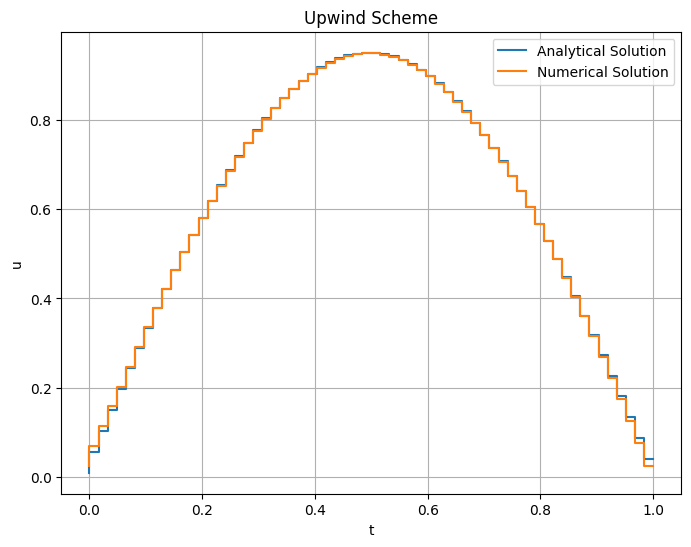

(array([0.00878099, 0.05621385, 0.10350695, 0.15054273, 0.19720422,
        0.24337544, 0.28894159, 0.33378938, 0.37780732, 0.42088598,
        0.46291824, 0.50379961, 0.54342846, 0.58170627, 0.61853785,
        0.65383166, 0.68749994, 0.71945898, 0.74962933, 0.77793599,
        0.80430858, 0.82868153, 0.85099425, 0.87119126, 0.88922235,
        0.90504269, 0.91861296, 0.92989941, 0.93887398, 0.94551437,
        0.94980406, 0.95173238, 0.95129455, 0.94849165, 0.94333065,
        0.93582438, 0.9259915 , 0.91385647, 0.89944944, 0.88280624,
        0.86396824, 0.84298229, 0.81990054, 0.7947804 , 0.7676843 ,
        0.73867962, 0.70783847, 0.67523752, 0.64095782, 0.6050846 ,
        0.56770705, 0.52891808, 0.48881414, 0.44749493, 0.40506318,
        0.36162438, 0.31728653, 0.27215985, 0.22635653, 0.17999046,
        0.13317691, 0.08603225, 0.03867371]),
 array([[0.02493069, 0.07473009, 0.1243437 , ..., 0.1243437 , 0.07473009,
         0.02493069],
        [0.02493069, 0.07441761, 0.1239926

In [358]:
solution = Solution(u=0.05, mu=0.5, L=10)
solution.run()